In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fredapi as fa

##### Functions

In [2]:
#may delete if not needed

def model_describe(model,returns):
    dfs = []
    cycle_df = returns[['Mkt-RF','SMB','HML','RMW','CMA','Mom',model]].apply(pd.to_numeric, errors='coerce').dropna()
    cycle_df[model] = cycle_df[model].round()
    for x in range(1,5):
        cycle = cycle_df.loc[cycle_df[model]==x]
        count = cycle_df.loc[cycle_df[model]==x].describe()[model][0]
        #print("Descriptive Stats during cycle {} which is {}/{}".format(x, count, len(cycle_df)))
        #print(cycle.describe()[['Mkt-RF','SMB','HML','RMW','CMA','Mom']].round(4))
        dfs.append(cycle.describe()[['Mkt-RF','SMB','HML','RMW','CMA','Mom']].round(4))
    return dfs

In [3]:
# get the optimal factors on 1 of 3 criteria
def get_fact(model,returns,sort):
    df = []
    cycle_df = returns[['Mkt-RF','SMB','HML','RMW','CMA','Mom',model]].apply(pd.to_numeric, errors='coerce').dropna()
    cycle_df[model] = cycle_df[model].round()
    for i in range(1,5):
        des = cycle_df.loc[cycle_df[model]==i].describe().drop([model,'Mkt-RF'], axis=1)
        if sort == 'Sharpe':
            optimal = (des.loc['mean']/des.loc['std']).idxmax()
        elif sort == 'Return':
            optimal = des.loc['mean'].idxmax()
        elif sort == 'VaR':
            optimal = cycle_df.loc[cycle_df[model]==1].drop([model,'Mkt-RF'], axis=1).quantile(0.05).idxmax()
        df.append(optimal)
    return df  

In [4]:
def returns_data(model, returns, opt,optw):    
    strat = returns[['Mkt-RF','SMB','HML','RMW','CMA','Mom',model]].apply(pd.to_numeric, errors='coerce').dropna()
    strat[model] = strat[model].round()
    #set up empy cells with for the weights
    for col in strat.columns:
        if 'cycle' in col:
            continue
        if 'Mkt' in col:
            continue
        else:
            strat[col + '_weight'] = 0
    #weight the cycle returns
    for col in strat.columns:
        if ('weight' in col) & (opt[0] in col):
            strat[col] = np.where(strat[model] == 1,optw[0],strat[col])
        if ('weight' in col) & (opt[1] in col):
            strat[col] = np.where(strat[model] == 2,optw[1],strat[col])
        if ('weight' in col) & (opt[2] in col):
            strat[col] = np.where(strat[model] == 3,optw[2],strat[col])
        if ('weight' in col) & (opt[3] in col):
            strat[col] = np.where(strat[model] == 4,optw[3],strat[col])

    #combine the returns
    strat['Rotation_return'] = strat['SMB']*strat['SMB_weight'] + \
                                strat['HML']*strat['HML_weight'] + \
                                strat['RMW']*strat['RMW_weight'] + \
                                strat['CMA']*strat['CMA_weight'] + \
                                strat['Mom']*strat['Mom_weight']
    strat = strat[['Mkt-RF','Rotation_return',model]]   

    #get cumaltive returns
    strat['Market'] = (strat['Mkt-RF']+1).cumprod()-1
    strat['Strategy'] = (strat['Rotation_return']+1).cumprod()-1
    return strat

In [5]:
#determine best returns by taking mode of best strategies looking at 4th through 0-1/4 to 1/4-1/2
def get_opt_overtime(model,returns,sort):
    df = returns[['Mkt-RF','SMB','HML','RMW','CMA','Mom',model]].apply(pd.to_numeric, errors='coerce').dropna()
    df_4th = round(len(df)/4)
    out_return = []
    in_return = []
    for x in range(df_4th):
        in_sample = df[0+x:df_4th+x]
        out_return.append(df[df_4th+x+1:])
        in_return.append(get_fact(model,in_sample,sort))
    opt = pd.DataFrame(in_return).mode().values.tolist()[0]
    return opt, out_return[-1]

In [6]:
#plot returns - add start and end dates
def cum_plot(df,df_label = 'Strategy',df1=None,df_label1 = 'Strategy',df2=None,df_label2 = 'Strategy'):
    plt.figure(figsize = (12,8))
    plt.plot(df.index,df['Market'], label='Market')
    plt.plot(df.index,df['Strategy'], label=df_label)

    #plot other strategies if want more than one vs the market
    if not isinstance(df1, type(None)):
        plt.plot(df1.index,df1['Strategy'], label=df_label1)
    if not isinstance(df2, type(None)):
        plt.plot(df2.index,df2['Strategy'], label=df_label2)

    plt.title("Cumulative Returns", fontsize = 30)

    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

def stats(df, time,market=False):
    #in qtrs may change to monthly
    mkt_vol = df['Mkt-RF'].std() * np.sqrt(time)
    mkt_ret = (df['Market'][-1]+1)**(1/(len(df)/time))-1
    mkt_sharpe = mkt_ret/mkt_vol

    strat_vol = df['Rotation_return'].std() * np.sqrt(time)
    strat_ret = (df['Strategy'][-1]+1)**(1/(len(df)/time))-1
    strat_sharpe = strat_ret/strat_vol


    if market:
        print("Market Return: {}%".format((100*mkt_ret).round(2)))
        print("Market Vol: {}%".format((100*mkt_vol).round(2)))
        print("Market Sharpe: {}".format(mkt_sharpe.round(2)))
        print("")
    else:
        #output important results
        print("Strategy Return: {}%".format((100*strat_ret).round(2)))
        print("Strategy Vol: {}%".format((100*strat_vol).round(2)))
        print("Strategy Sharpe: {}".format(strat_sharpe.round(2)))

#### Get Quarterly data for models

In [7]:
#pull data from FRED
fred = fa.Fred(api_key='b6bbb1bfe76d93bf0ca60a69b99d3474')

#CPI
cpi = fred.get_series('CPIAUCSL')
cpi.name = 'CPI'

cpi_data = pd.DataFrame(index=cpi.index,data=cpi.values,columns=['CPI']).dropna()
cpi_data['CPI YOY'] = cpi_data['CPI'].rolling(12).apply(lambda x: (x.iloc[-1]/x.iloc[0] - 1) *100 )
cpi_data['CPI'] = cpi_data['CPI YOY'].rolling(12).apply(lambda x: x.iloc[-1] -x.iloc[0] - 1)
cpi_data = cpi_data.dropna()

#GDP
gdp = fred.get_series('GDP')
gdp.name = 'GDP'

gdp_data = pd.DataFrame(index=gdp.index,data=gdp.values,columns=['GDP']).dropna()
gdp_data['GDP YOY'] = gdp_data['GDP'].rolling(4).apply(lambda x: (x.iloc[-1]/x.iloc[0] - 1) *100 )
gdp_data['GDP'] = gdp_data['GDP YOY'].rolling(4).apply(lambda x: x.iloc[-1] -x.iloc[0] - 1)
gdp_data = gdp_data.dropna()

#merge data
df = pd.concat([gdp_data, cpi_data], axis=1).dropna()

#make cycle
conditions = [
    (df['CPI'] < 0.0) & (df['GDP'] >= 0.0),
    (df['CPI'] >= 0.0) & (df['GDP'] >= 0.0), #& (df['GDP YOY'] > 0.5),
    (df['CPI'] < 0.0) & (df['GDP'] < 0.0)]
choices = [1.0, 2.0, 4.0]
df['cycle_gdp_cpi'] = np.select(conditions, choices, default=3.0)

#shift to get the 1 qtr
df = df.shift(1).dropna()

In [8]:
#HY Cycle builder
hyoas = fred.get_series('BAMLH0A0HYM2')
hyoas.name = 'HY_OAS'

data = pd.DataFrame(index=hyoas.index,data=hyoas.values,columns=['HY OAS']).dropna()

#ten year median
median_10y = data['HY OAS'].rolling('3650D').median()

#3 month rising or falling: 1 is rising
return_3m = (data['HY OAS'].pct_change()+1).rolling('91D').apply(np.prod)-1
return_3m = pd.DataFrame(index= return_3m.index, data= np.where(return_3m > 0, 1,0))

#add to data frame
data['10y Median'] = median_10y
data['3M Up/Down'] = return_3m

#make HY cycle
conditions = [
    (data['HY OAS']>data['10y Median']) & (data['3M Up/Down']==0),
    (data['HY OAS']<data['10y Median']) & (data['3M Up/Down']==0),
    (data['HY OAS']<data['10y Median']) & (data['3M Up/Down']==1)
]

choices = [1,2,3]

data['cycle_hy'] = np.select(conditions, choices, default = 4)

data= data.shift(1).dropna()

#convert to qtrly to match GDP - may want both in monthly
data = data.resample('Q', label='left').mean() #may want to round
data = data.reset_index()
data['date'] = data['index'] + pd.DateOffset(1)
data = data[['date','cycle_hy']]
data.set_index('date',inplace=True)


#combine both HY and GDP
model_df = pd.concat([data, df], axis=1)
model_df = model_df[['cycle_hy','cycle_gdp_cpi']].fillna('-')
#model_df


Returns from the factors

In [9]:
facts = pd.read_csv("Factors.csv",header=3)
facts = facts.drop("String",axis=1)
facts['Date'] = pd.to_datetime(facts['Date'])
facts = facts.set_index("Date")
facts = facts.apply(pd.to_numeric)/100

#resample to qtrs to match the
facts += 1
facts = facts.rolling(3).apply(lambda x: x.prod()-1).dropna()
#facts.describe()#.to_excel('Factor Des Stats.xlsx')

#merge to get model and return
returns = pd.concat([facts, model_df], axis=1).dropna()
returns = returns[['Mkt-RF','SMB','HML','RMW','CMA','Mom','cycle_hy','cycle_gdp_cpi']]
returns

,Mkt-RF,SMB,HML,RMW,CMA,Mom,cycle_hy,cycle_gdp_cpi
1963-10-01,0.060369,-0.026875,0.018304,0.024376,-0.020698,0.043594,-,1.0
1964-01-01,0.032260,-0.028354,0.032352,-0.003110,0.036703,0.018656,-,1.0
1964-04-01,0.030747,-0.000296,0.055933,-0.035002,0.030344,0.004261,-,1.0
1964-07-01,0.044952,0.001565,0.032602,-0.003599,0.019097,0.026812,-,4.0
1964-10-01,0.018084,0.009392,0.029722,-0.008688,0.014467,-0.005496,-,4.0
...,...,...,...,...,...,...,...,...
2021-07-01,0.043567,-0.037751,-0.030309,0.058010,0.015417,0.007801,2.343284,2.0
2021-10-01,0.049573,-0.022501,0.044083,-0.005512,-0.011026,0.073981,2.5,2.0
2022-01-01,-0.048419,-0.064645,0.159358,0.134739,0.144387,-0.042688,2.828125,3.0
2022-04-01,-0.088351,0.003434,0.074486,-0.001085,0.126981,0.099381,3.538462,3.0


,Label
Date,
1990-01-01,3
1990-02-01,3
1990-03-01,3
1990-05-01,3
1990-06-01,3
...,...
2022-07-01,2
2022-08-01,2
2022-09-01,1


## Train and test on entire Data set
#### GDP and Inflation - Qtrly

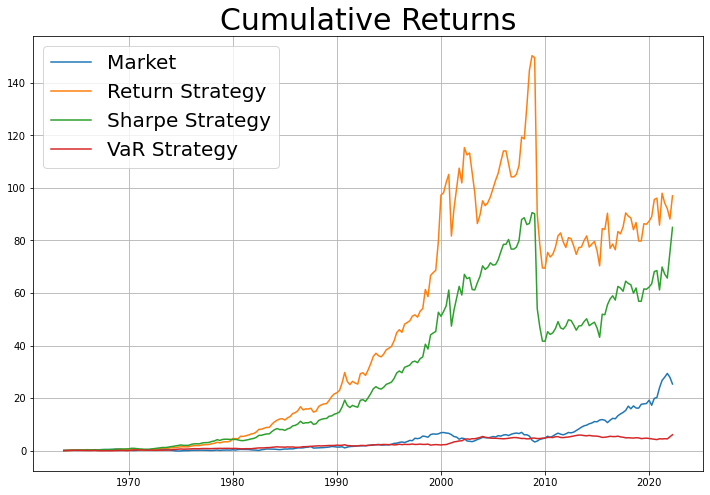

Return Strategy for cycle 1-4: ['HML', 'SMB', 'Mom', 'Mom']
Sharpe Strategy for cycle 1-4: ['HML', 'SMB', 'CMA', 'Mom']
Var Strategy for cycle 1-4: ['CMA', 'CMA', 'CMA', 'CMA']


In [20]:
#inputs to custum strategy
model = 'cycle_gdp_cpi'

#Gdp
gdp_opt_return = get_fact(model,returns,'Return')
gdp_opt_sharpe = get_fact(model,returns,'Sharpe')
gdp_opt_var = get_fact(model,returns,'VaR')

gdp_opt_1w = 1
gdp_opt_2w = 1
gdp_opt_3w = 1
gdp_opt_4w = 1

gdp_opt_w = [gdp_opt_1w,gdp_opt_2w,gdp_opt_3w,gdp_opt_4w]


#add start and end dates
cum_plot(returns_data(model, returns,gdp_opt_return,gdp_opt_w),"Return Strategy",
         returns_data(model, returns,gdp_opt_sharpe,gdp_opt_w),"Sharpe Strategy",
         returns_data(model, returns,gdp_opt_var,gdp_opt_w),"VaR Strategy")

print("Return Strategy for cycle 1-4: {}".format(gdp_opt_return))
print("Sharpe Strategy for cycle 1-4: {}".format(gdp_opt_sharpe))
print("Var Strategy for cycle 1-4: {}".format(gdp_opt_var))

In [21]:
#stats
print("Market")
stats(returns_data(model, returns,gdp_opt_return,gdp_opt_w),4, True)
print("\nBest Return Strategy")
stats(returns_data(model, returns,gdp_opt_return,gdp_opt_w),4)
print("\nBest Return Sharpe")
stats(returns_data(model, returns,gdp_opt_sharpe,gdp_opt_w),4)
print("\nBest Return Historical VaR")
stats(returns_data(model, returns,gdp_opt_var,gdp_opt_w),4)

Market
Market Return: 5.73%
Market Vol: 14.57%
Market Sharpe: 0.39


Best Return Strategy
Strategy Return: 8.12%
Strategy Vol: 13.24%
Strategy Sharpe: 0.61

Best Return Sharpe
Strategy Return: 7.88%
Strategy Vol: 12.44%
Strategy Sharpe: 0.63

Best Return Historical VaR
Strategy Return: 3.37%
Strategy Vol: 7.63%
Strategy Sharpe: 0.44


#### High Yield - Qtrly

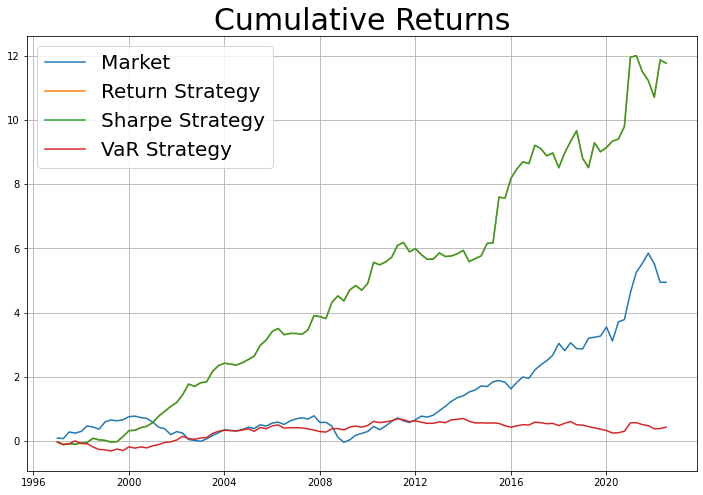

Return Strategy for cycle 1-4: ['SMB', 'SMB', 'Mom', 'Mom']
Sharpe Strategy for cycle 1-4: ['SMB', 'SMB', 'Mom', 'Mom']
Var Strategy for cycle 1-4: ['SMB', 'SMB', 'SMB', 'SMB']


In [22]:
#HY Opt for each by qtr
model = 'cycle_hy'

hy_opt_return = get_fact(model,returns,'Return')
hy_opt_sharpe = get_fact(model,returns,'Sharpe')
hy_opt_var = get_fact(model,returns,'VaR')

hy_opt_1w = 1
hy_opt_2w = 1
hy_opt_3w = 1
hy_opt_4w = 1

hy_opt_w = [hy_opt_1w,hy_opt_2w,hy_opt_3w,hy_opt_4w]

#Plot for entire time period
cum_plot(returns_data(model, returns,hy_opt_return,hy_opt_w),"Return Strategy",
         returns_data(model, returns,hy_opt_sharpe,hy_opt_w),"Sharpe Strategy",
         returns_data(model, returns,hy_opt_var,hy_opt_w),"VaR Strategy")

print("Return Strategy for cycle 1-4: {}".format(hy_opt_return))
print("Sharpe Strategy for cycle 1-4: {}".format(hy_opt_sharpe))
print("Var Strategy for cycle 1-4: {}".format(hy_opt_var))

In [23]:
#stats
print("Market")
stats(returns_data(model, returns,hy_opt_return,hy_opt_w),4, True)
print("\nBest Return Strategy")
stats(returns_data(model, returns,hy_opt_return,hy_opt_w),4)
print("\nBest Return Sharpe")
stats(returns_data(model, returns,hy_opt_sharpe,hy_opt_w),4)
print("\nBest Return Historical VaR")
stats(returns_data(model, returns,hy_opt_var,hy_opt_w),4)

Market
Market Return: 7.17%
Market Vol: 14.57%
Market Sharpe: 0.49


Best Return Strategy
Strategy Return: 10.4%
Strategy Vol: 11.07%
Strategy Sharpe: 0.94

Best Return Sharpe
Strategy Return: 10.4%
Strategy Vol: 11.07%
Strategy Sharpe: 0.94

Best Return Historical VaR
Strategy Return: 1.41%
Strategy Vol: 10.45%
Strategy Sharpe: 0.13


#### High Yield Model - Monthly
###### Get Monthly Data

In [22]:
#HY Cycle builder
hyoas = fred.get_series('BAMLH0A0HYM2')
hyoas.name = 'HY_OAS'

data = pd.DataFrame(index=hyoas.index,data=hyoas.values,columns=['HY OAS']).dropna()

#ten year median
median_10y = data['HY OAS'].rolling('3650D').median()

#3 month rising or falling: 1 is rising
return_3m = (data['HY OAS'].pct_change()+1).rolling('91D').apply(np.prod)-1
return_3m = pd.DataFrame(index= return_3m.index, data= np.where(return_3m > 0, 1,0))

#add to data frame
data['10y Median'] = median_10y
data['3M Up/Down'] = return_3m

#make HY cycle
conditions = [
    (data['HY OAS']>data['10y Median']) & (data['3M Up/Down']==0),
    (data['HY OAS']<data['10y Median']) & (data['3M Up/Down']==0),
    (data['HY OAS']<data['10y Median']) & (data['3M Up/Down']==1)
]

choices = [1,2,3]

data['cycle_hy'] = np.select(conditions, choices, default = 4)

#lag by a day since it takes a day to get the HY OAS
data = data.shift(1).dropna()
#convert to monthly to match factor returns - reblance monthly
data = data.resample('M', label='left').mean() #may want to round
data = data.reset_index()
data['date'] = data['index'] + pd.DateOffset(1)
data = data[['date','cycle_hy']]
data.set_index('date',inplace=True)

#get factor data
facts = pd.read_csv("Factors.csv",header=3)
facts = facts.drop("String",axis=1)
facts['Date'] = pd.to_datetime(facts['Date'])
facts = facts.set_index("Date")
facts = facts.apply(pd.to_numeric)/100
#facts.describe()#.to_excel('HY Factor Des Stats.xlsx')

#merge to get model and return
returns_m = pd.concat([facts,data], axis=1).dropna()
returns_m

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom,cycle_hy
1997-01-01,0.0499,-0.0182,-0.0142,0.0119,-0.0002,0.0045,0.0196,2.272727
1997-02-01,-0.0049,-0.0259,0.0567,0.0067,0.0347,0.0039,-0.0213,2.105263
1997-03-01,-0.0503,-0.0043,0.0339,0.0050,0.0166,0.0043,0.0090,2.000000
1997-04-01,0.0404,-0.0570,0.0007,0.0326,-0.0072,0.0043,0.0484,2.090909
1997-05-01,0.0674,0.0475,-0.0413,-0.0102,-0.0296,0.0049,-0.0517,1.954545
...,...,...,...,...,...,...,...,...
2022-04-01,-0.0946,-0.0040,0.0619,0.0363,0.0592,0.0001,0.0489,3.000000
2022-05-01,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0003,0.0248,3.681818
2022-06-01,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0006,0.0079,3.909091
2022-07-01,0.0957,0.0187,-0.0410,0.0068,-0.0694,0.0008,-0.0396,4.000000


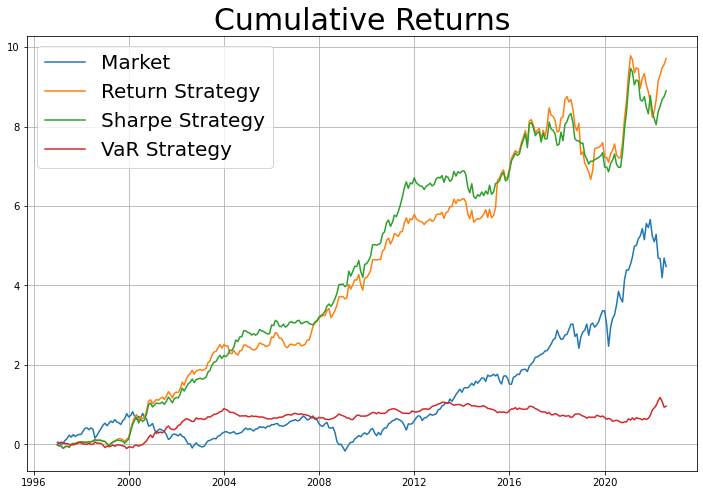

Return Strategy for cycle 1-4: ['SMB', 'SMB', 'Mom', 'RMW']
Sharpe Strategy for cycle 1-4: ['SMB', 'SMB', 'RMW', 'RMW']
Var Strategy for cycle 1-4: ['CMA', 'CMA', 'CMA', 'CMA']


In [25]:
#HY Opt for each by qtr

model = 'cycle_hy'

hy_opt_return = get_fact(model,returns_m,'Return')
hy_opt_sharpe = get_fact(model,returns_m,'Sharpe')
hy_opt_var = get_fact(model,returns_m,'VaR')

hy_opt_1w = 1
hy_opt_2w = 1
hy_opt_3w = 1
hy_opt_4w = 1

hy_opt_w = [hy_opt_1w,hy_opt_2w,hy_opt_3w,hy_opt_4w]

#Plot for entire time period
cum_plot(returns_data(model, returns_m,hy_opt_return,hy_opt_w),"Return Strategy",
         returns_data(model, returns_m,hy_opt_sharpe,hy_opt_w),"Sharpe Strategy",
         returns_data(model, returns_m,hy_opt_var,hy_opt_w),"VaR Strategy")

print("Return Strategy for cycle 1-4: {}".format(hy_opt_return))
print("Sharpe Strategy for cycle 1-4: {}".format(hy_opt_sharpe))
print("Var Strategy for cycle 1-4: {}".format(hy_opt_var))

### HY Monthly Stats - Total Period

In [26]:
print("Market")
stats(returns_data(model, returns_m,hy_opt_return,hy_opt_w),12,True)
print("\nBest Return Strategy")
stats(returns_data(model, returns_m,hy_opt_return,hy_opt_w),12)
print("\nBest Return Sharpe")
stats(returns_data(model, returns_m,hy_opt_sharpe,hy_opt_w),12)
print("\nBest Return Historical VaR")
stats(returns_data(model, returns_m,hy_opt_var,hy_opt_w),12)

Market
Market Return: 6.85%
Market Vol: 16.1%
Market Sharpe: 0.43


Best Return Strategy
Strategy Return: 9.68%
Strategy Vol: 10.82%
Strategy Sharpe: 0.89

Best Return Sharpe
Strategy Return: 9.34%
Strategy Vol: 10.18%
Strategy Sharpe: 0.92

Best Return Historical VaR
Strategy Return: 2.65%
Strategy Vol: 7.75%
Strategy Sharpe: 0.34


# Train over different time periods
#### GDP + CPI (Quarterly)

In [27]:
#solid wieghts currently
gdp_opt_1w = 1
gdp_opt_2w = 1
gdp_opt_3w = 1
gdp_opt_4w = 1

gdp_opt_w = [gdp_opt_1w,gdp_opt_2w,gdp_opt_3w,gdp_opt_4w]

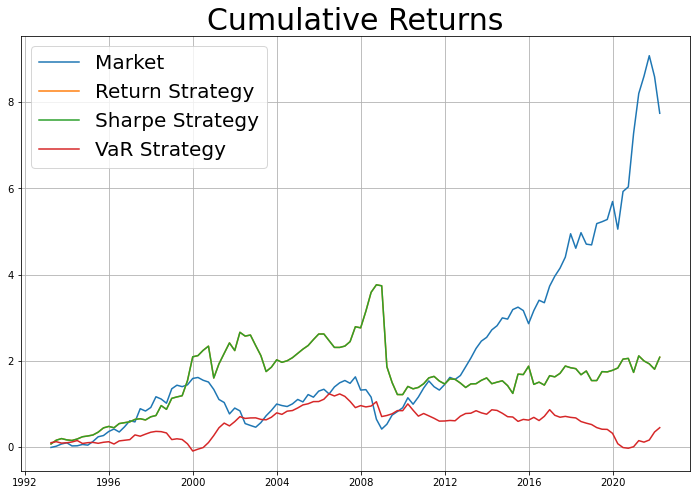

Return Strategy for cycle 1-4: ['HML', 'SMB', 'Mom', 'Mom']
Sharpe Strategy for cycle 1-4: ['HML', 'SMB', 'Mom', 'Mom']
Var Strategy for cycle 1-4: ['HML', 'HML', 'HML', 'HML']


In [28]:
#inputs to custum strategy
model = 'cycle_gdp_cpi'

#Gdp
gdp_opt_return, out = get_opt_overtime(model,returns,"Return")
gdp_opt_sharpe, out = get_opt_overtime(model,returns,"Sharpe")
gdp_opt_var, out = get_opt_overtime(model,returns,"VaR")

gdp_opt_1w = 1
gdp_opt_2w = 1
gdp_opt_3w = 1
gdp_opt_4w = 1

gdp_opt_w = [gdp_opt_1w,gdp_opt_2w,gdp_opt_3w,gdp_opt_4w]


#add start and end dates
cum_plot(returns_data(model, out,gdp_opt_return,gdp_opt_w),"Return Strategy",
         returns_data(model, out,gdp_opt_sharpe,gdp_opt_w),"Sharpe Strategy",
         returns_data(model, out,gdp_opt_var,gdp_opt_w),"VaR Strategy")

print("Return Strategy for cycle 1-4: {}".format(gdp_opt_return))
print("Sharpe Strategy for cycle 1-4: {}".format(gdp_opt_sharpe))
print("Var Strategy for cycle 1-4: {}".format(gdp_opt_var))

In [37]:
#stats
print("Market")
stats(returns_data(model, out,gdp_opt_return,gdp_opt_w),4, True)
print("\nBest Return Strategy")
stats(returns_data(model, out,gdp_opt_return,gdp_opt_w),4)
print("\nBest Return Sharpe")
stats(returns_data(model, out,gdp_opt_sharpe,gdp_opt_w),4)
print("\nBest Return Historical VaR")
stats(returns_data(model, out,gdp_opt_var,gdp_opt_w),4)

Market
Market Return: 7.69%
Market Vol: 14.07%
Market Sharpe: 0.55


Best Return Strategy
Strategy Return: 3.93%
Strategy Vol: 15.17%
Strategy Sharpe: 0.26

Best Return Sharpe
Strategy Return: 3.93%
Strategy Vol: 15.17%
Strategy Sharpe: 0.26

Best Return Historical VaR
Strategy Return: 1.28%
Strategy Vol: 11.51%
Strategy Sharpe: 0.11


#### HY Training over time

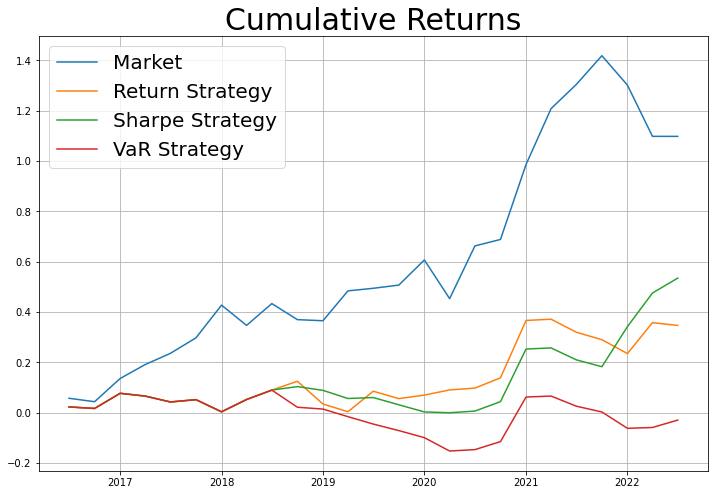

Return Strategy for cycle 1-4: ['SMB', 'SMB', 'Mom', 'Mom']
Sharpe Strategy for cycle 1-4: ['SMB', 'SMB', 'RMW', 'Mom']
Var Strategy for cycle 1-4: ['SMB', 'SMB', 'SMB', 'SMB']


In [22]:
model = 'cycle_hy'

hy_opt_return,out_hy = get_opt_overtime(model,returns,"Return")
hy_opt_sharpe,out_hy = get_opt_overtime(model,returns,"Sharpe")
hy_opt_var,out_hy = get_opt_overtime(model,returns,"VaR")

hy_opt_1w = 1
hy_opt_2w = 1
hy_opt_3w = 1
hy_opt_4w = 1

hy_opt_w = [hy_opt_1w,hy_opt_2w,hy_opt_3w,hy_opt_4w]

#Plot for entire time period
cum_plot(returns_data(model, out_hy,hy_opt_return,hy_opt_w),"Return Strategy",
         returns_data(model, out_hy,hy_opt_sharpe,hy_opt_w),"Sharpe Strategy",
         returns_data(model, out_hy,hy_opt_var,hy_opt_w),"VaR Strategy")

print("Return Strategy for cycle 1-4: {}".format(hy_opt_return))
print("Sharpe Strategy for cycle 1-4: {}".format(hy_opt_sharpe))
print("Var Strategy for cycle 1-4: {}".format(hy_opt_var))

In [23]:
#stats
print("Market")
stats(returns_data(model, out_hy,hy_opt_return,hy_opt_w),4, True)
print("\nBest Return Strategy")
stats(returns_data(model, out_hy,hy_opt_return,hy_opt_w),4)
print("\nBest Return Sharpe")
stats(returns_data(model, out_hy,hy_opt_sharpe,hy_opt_w),4)
print("\nBest Return Historical VaR")
stats(returns_data(model, out_hy,hy_opt_var,hy_opt_w),4)

Market
Market Return: 12.59%
Market Vol: 13.62%
Market Sharpe: 0.92


Best Return Strategy
Strategy Return: 4.88%
Strategy Vol: 11.36%
Strategy Sharpe: 0.43

Best Return Sharpe
Strategy Return: 7.1%
Strategy Vol: 11.37%
Strategy Sharpe: 0.62

Best Return Historical VaR
Strategy Return: -0.47%
Strategy Vol: 10.79%
Strategy Sharpe: -0.04


#### High Yield Monthly over different traing period

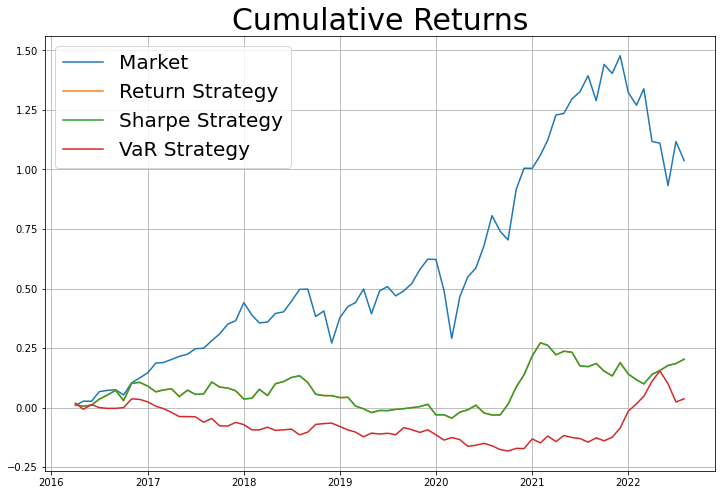

Return Strategy for cycle 1-4: ['SMB', 'SMB', 'RMW', 'RMW']
Sharpe Strategy for cycle 1-4: ['SMB', 'SMB', 'RMW', 'RMW']
Var Strategy for cycle 1-4: ['CMA', 'CMA', 'CMA', 'CMA']


In [24]:
model = 'cycle_hy'

hy_opt_return,out_hym = get_opt_overtime(model,returns_m,"Return")
hy_opt_sharpe,out_hym = get_opt_overtime(model,returns_m,"Sharpe")
hy_opt_var,out_hym = get_opt_overtime(model,returns_m,"VaR")

hy_opt_1w = 1
hy_opt_2w = 1
hy_opt_3w = 1
hy_opt_4w = 1

hy_opt_w = [hy_opt_1w,hy_opt_2w,hy_opt_3w,hy_opt_4w]

#Plot for entire time period
cum_plot(returns_data(model, out_hym,hy_opt_return,hy_opt_w),"Return Strategy",
         returns_data(model, out_hym,hy_opt_sharpe,hy_opt_w),"Sharpe Strategy",
         returns_data(model, out_hym,hy_opt_var,hy_opt_w),"VaR Strategy")

print("Return Strategy for cycle 1-4: {}".format(hy_opt_return))
print("Sharpe Strategy for cycle 1-4: {}".format(hy_opt_sharpe))
print("Var Strategy for cycle 1-4: {}".format(hy_opt_var))

In [25]:
print("Market")
stats(returns_data(model, out_hym,hy_opt_return,hy_opt_w),12,True)
print("\nBest Return Strategy")
stats(returns_data(model, out_hym,hy_opt_return,hy_opt_w),12)
print("\nBest Return Sharpe")
stats(returns_data(model, out_hym,hy_opt_sharpe,hy_opt_w),12)
print("\nBest Return Historical VaR")
stats(returns_data(model, out_hym,hy_opt_var,hy_opt_w),12)

Market
Market Return: 11.73%
Market Vol: 16.32%
Market Sharpe: 0.72


Best Return Strategy
Strategy Return: 2.92%
Strategy Vol: 9.33%
Strategy Sharpe: 0.31

Best Return Sharpe
Strategy Return: 2.92%
Strategy Vol: 9.33%
Strategy Sharpe: 0.31

Best Return Historical VaR
Strategy Return: 0.57%
Strategy Vol: 8.41%
Strategy Sharpe: 0.07


In [39]:


yield_mod =pd.read_csv('monthly.csv',usecols=['Date','Label'])
yield_mod['Date'] = pd.to_datetime(yield_mod['Date'])
yield_mod['Label'] = yield_mod['Label'] + 1
yield_mod = yield_mod.set_index("Date")

ys_returns = pd.concat([facts,yield_mod],axis=1).dropna()

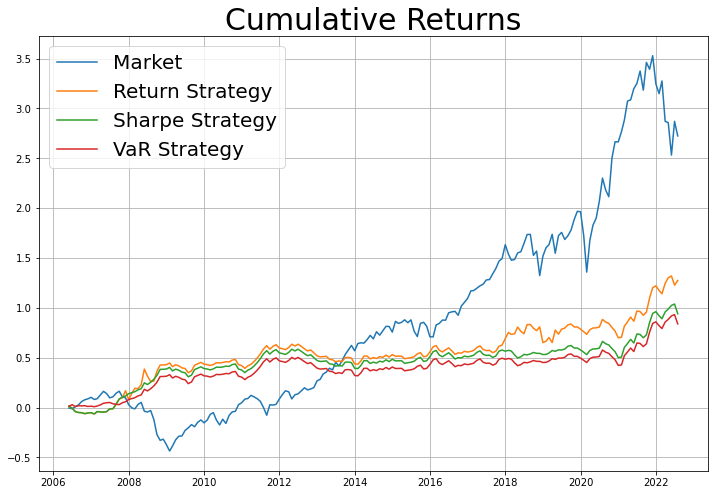

Return Strategy for cycle 1-4: ['RMW', 'Mom', 'Mom', 'Mom']
Sharpe Strategy for cycle 1-4: ['RMW', 'Mom', 'RMW', 'Mom']
Var Strategy for cycle 1-4: ['RMW', 'RMW', 'RMW', 'RMW']


In [73]:
model = 'Label'

opt_return = get_fact(model,ys_returns,"Return")
opt_sharpe = get_fact(model,ys_returns,"Sharpe")
opt_var = get_fact(model,ys_returns,"VaR")

opt_return1,out1 = get_opt_overtime(model,ys_returns,"Return")

hy_opt_1w = 1
hy_opt_2w = 1
hy_opt_3w = 1
hy_opt_4w = 1

hy_opt_w = [hy_opt_1w,hy_opt_2w,hy_opt_3w,hy_opt_4w]

#Plot for entire time period
cum_plot(returns_data(model, out1,opt_return,hy_opt_w),"Return Strategy",
         returns_data(model, out1,opt_sharpe,hy_opt_w),"Sharpe Strategy",
         returns_data(model, out1,opt_var,hy_opt_w),"VaR Strategy")

print("Return Strategy for cycle 1-4: {}".format(opt_return))
print("Sharpe Strategy for cycle 1-4: {}".format(opt_sharpe))
print("Var Strategy for cycle 1-4: {}".format(opt_var))

In [71]:
print("Market")
stats(returns_data(model, out1,opt_return,hy_opt_w),12,True)
print("\nBest Return Strategy")
stats(returns_data(model, out1,opt_return,hy_opt_w),12)
print("\nBest Return Sharpe")
stats(returns_data(model, out1,opt_sharpe,hy_opt_w),12)
print("\nBest Return Historical VaR")
stats(returns_data(model, out1,opt_var,hy_opt_w),12)

Market
Market Return: 8.43%
Market Vol: 15.96%
Market Sharpe: 0.53


Best Return Strategy
Strategy Return: 5.19%
Strategy Vol: 9.08%
Strategy Sharpe: 0.57

Best Return Sharpe
Strategy Return: 4.16%
Strategy Vol: 6.71%
Strategy Sharpe: 0.62

Best Return Historical VaR
Strategy Return: 3.82%
Strategy Vol: 6.4%
Strategy Sharpe: 0.6


In [83]:
import statsmodels.api as sm

beta_info = returns_data(model, out1,opt_sharpe,hy_opt_w)
beta_info1 = returns_data(model, ys_returns,opt_sharpe,hy_opt_w)

#rf = facts['RF']

X = beta_info['Mkt-RF']
Y = beta_info['Rotation_return']
X = sm.add_constant(X)

reg = sm.OLS(Y, X).fit()

X1 = beta_info1['Mkt-RF']
Y1 = beta_info1['Rotation_return']
X1 = sm.add_constant(X1)

reg1 = sm.OLS(Y1, X1).fit()

In [86]:
print("test on second half")
print(reg.params)
print("")
print("test on entire data")
print(reg1.params)

test on second half
const     0.004233
Mkt-RF   -0.081846
dtype: float64

test on entire data
const     0.007092
Mkt-RF   -0.105255
dtype: float64
